In [1]:
import torchvision.transforms
import source.data
import source.utils
import math
import torch.hub
import torch.utils.data
import torch
import torch.optim
import source.modules

import torchvision.models.segmentation
import random
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
_  = torch.manual_seed(0)

cpu_device = torch.device('cpu')
device = torch.device('cuda:0')

torch.cuda.empty_cache()

In [2]:
image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.AugmentedPascalPartDataset(
    transform=image_transform,
    target_transform=mask_transform
)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=8)

weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = torchvision.models.segmentation.fcn_resnet50(weights=weights, progress=False)

classifier = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1, inplace=False),
    torch.nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1))
)

model.classifier = classifier
model.aux_classifier = torch.nn.Identity()

optimizer = torch.optim.AdamW(
    [
        {'params':model.classifier.parameters()},
        {'params':model.backbone.parameters(), 'lr': 1e-4}
    ], lr=0.001
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000], gamma=0.1)
loss_function = source.utils.FocalLoss(gamma=2)

In [3]:
_ = (
    model.to(device),
    loss_function.to(device),
)

In [4]:
metrics_tracker: dict[int, list[float]] = {index:[] for index in range(-1, 10)}
n_epochs = 20

for epoch in range(n_epochs):
    for iteration, (images, masks) in enumerate(dataloader):

        images = images.to(device)
        masks = masks.to(device)
        
        output_logits = model(images)['out']

        output_loss_value = loss_function(
            output_logits,
            masks
        )

        optimizer.zero_grad()
        output_loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=torch.nn.functional.log_softmax(output_logits, dim=1),
            masks=masks,
            classes=list(dataset.class_to_name.keys()),
        )
        
        metrics_tracker[-1].append(output_loss_value.to(cpu_device).detach().item())
        for object_class in range(0, 10):
            metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class][
                   intersection_over_union_per_class[object_class] >= 0. 
                ].to(cpu_device).detach().mean().item()
            )
        
        if iteration % 5 == 0:
            print(
                f"Iteration: {epoch * len(dataloader) + iteration}" +
                f"/ {n_epochs*len(dataloader)} "
                f"Loss value: {metrics_tracker[-1][-1]:.3f} \t ",
                "IoU - ",
                *[
                    f"{dataset.class_to_name[object_class]} : " +
                    f"{metrics_tracker[object_class][-1]:.3f} \t "
                    for object_class in list(dataset.class_to_name.keys())
                ],
                f"upper_body: {metrics_tracker[7][-1]:.3f} \t ",
                f"lower_body: {metrics_tracker[8][-1]:.3f} \t ",
                f"body: {metrics_tracker[9][-1]:.3f} \t ",
            )

Iteration: 0/ 7080 Loss value: 1.414 	  IoU -  bg : 0.152 	  low_hand : 0.006 	  torso : 0.001 	  low_leg : 0.003 	  head : 0.037 	  up_leg : 0.016 	  up_hand : 0.008 	  upper_body: 0.054 	  lower_body: 0.018 	  body: 0.121 	 
Iteration: 5/ 7080 Loss value: 0.447 	  IoU -  bg : 0.877 	  low_hand : 0.048 	  torso : 0.216 	  low_leg : 0.019 	  head : 0.277 	  up_leg : 0.049 	  up_hand : 0.000 	  upper_body: 0.319 	  lower_body: 0.050 	  body: 0.516 	 
Iteration: 10/ 7080 Loss value: 0.502 	  IoU -  bg : 0.752 	  low_hand : 0.027 	  torso : 0.332 	  low_leg : 0.000 	  head : 0.491 	  up_leg : 0.004 	  up_hand : 0.069 	  upper_body: 0.286 	  lower_body: 0.004 	  body: 0.449 	 
Iteration: 15/ 7080 Loss value: 0.260 	  IoU -  bg : 0.911 	  low_hand : 0.000 	  torso : 0.357 	  low_leg : 0.008 	  head : 0.459 	  up_leg : 0.059 	  up_hand : 0.013 	  upper_body: 0.222 	  lower_body: 0.067 	  body: 0.576 	 
Iteration: 20/ 7080 Loss value: 0.223 	  IoU -  bg : 0.935 	  low_hand : 0.013 	  torso : 

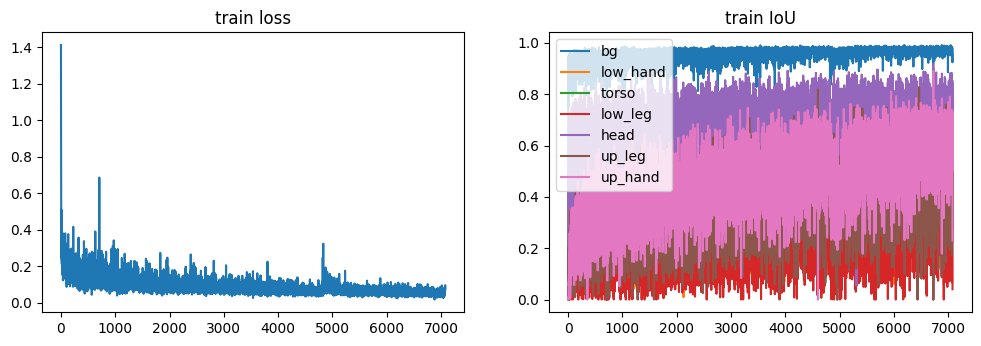

In [5]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 8))

figure.add_subplot(2, 2, 1)
plt.plot(metrics_tracker[-1], label="")
plt.title("train loss")

figure.add_subplot(2, 2, 2)
[
    plt.plot(metrics_tracker[index], label=dataset.class_to_name[index])
    for index in range(0, 7)
]
plt.legend()
plt.title("train IoU")

plt.show()

# metrics on eval

In [6]:
evaluation_dataset = source.data.PascalPartDataset(
    transform=image_transform,
    train=False,
)
_ = model.eval()
evaluation_metrics_tracker = {index:[] for index in range(0, 10)}

In [7]:
with torch.no_grad():
    for image, mask in evaluation_dataset:
        image = image.to(device)
        mask = mask.to(device)
        
        mask_shape = mask.shape
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output_logits = model(image)['out']

        log_probabilities = torch.nn.functional.log_softmax(
            output_logits,
            dim=1, # 1 x C x H x W
        )

        upsampled_log_probabilities = torch.nn.functional.interpolate(
            input=log_probabilities,
            size=mask_shape,
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=upsampled_log_probabilities,
            masks=mask,
            classes=list(dataset.class_to_name.keys()),
        )

        for object_class in range(0, 10):
            filtered_iou = intersection_over_union_per_class[object_class][
                intersection_over_union_per_class[object_class] >= 0.
            ].to(cpu_device).detach()
            if filtered_iou.numel():
                evaluation_metrics_tracker[object_class].append(filtered_iou.mean().item())

print(
    "IoU - ",
    *[
        f"{evaluation_dataset.class_to_name[object_class]} : " +
        f"{sum(evaluation_metrics_tracker[object_class]) / len(evaluation_metrics_tracker[object_class]):.3f} \t "
        for object_class in list(evaluation_dataset.class_to_name.keys())
    ],
    f"upper_body: {sum(evaluation_metrics_tracker[7]) / len(evaluation_metrics_tracker[7]):.3f} \t ",
    f"lower_body: {sum(evaluation_metrics_tracker[8]) / len(evaluation_metrics_tracker[8]):.3f} \t ",
    f"body: {sum(evaluation_metrics_tracker[9]) / len(evaluation_metrics_tracker[9]):.3f} \t ",
)

IoU -  bg : 0.938 	  low_hand : 0.400 	  torso : 0.578 	  low_leg : 0.334 	  head : 0.712 	  up_leg : 0.389 	  up_hand : 0.452 	  upper_body: 0.320 	  lower_body: 0.439 	  body: 0.725 	 


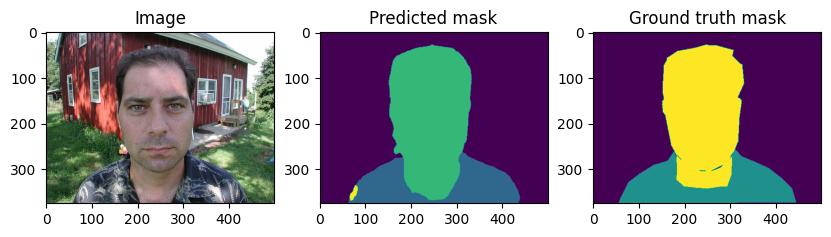

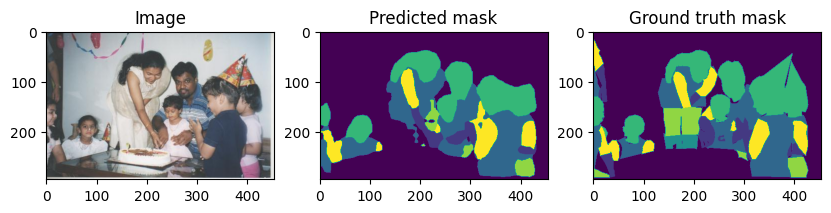

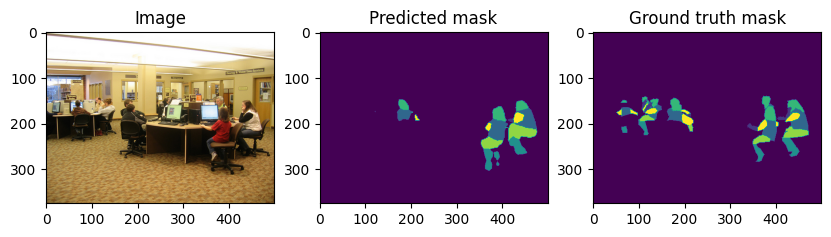

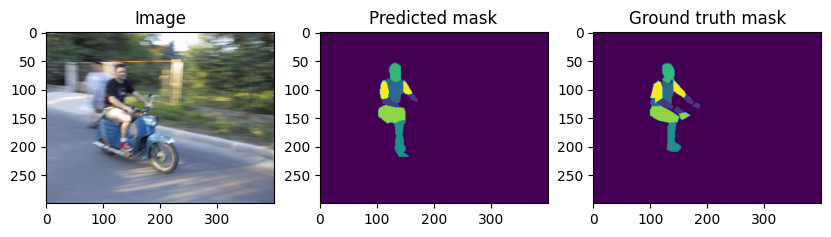

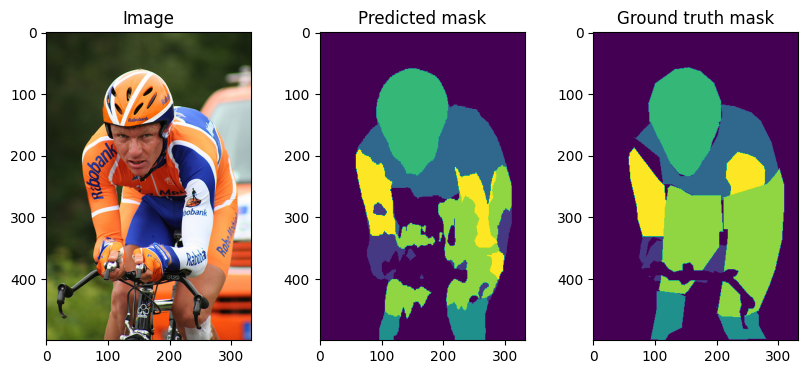

In [10]:
for _ in range(5):
    random_index = torch.randint(0, len(evaluation_dataset), size=(1, )).item()
    original_image, original_mask = source.data.PascalPartDataset(train=False)[random_index]
    mask_shape = original_mask.shape
    image = image_transform(original_image).unsqueeze(0)
    mask = mask.unsqueeze(0)

    image = image.to(device)
    output_logits = model(image)['out']


    log_probabilities = torch.nn.functional.log_softmax(
        output_logits,
        dim=1, # 1 x C x H x W
    )
    upsampled_log_probabilities = torch.nn.functional.interpolate(
        input=log_probabilities,
        size=mask_shape,
    )
    predicted_mask = upsampled_log_probabilities.argmax(
        dim=1
    ).squeeze().to(cpu_device)

    figure = plt.figure(figsize=(10, 4))

    figure.add_subplot(1, 3, 1)
    plt.imshow(original_image.squeeze().permute(1, 2, 0))
    plt.title("Image")

    figure.add_subplot(1, 3, 2)
    plt.imshow(predicted_mask)
    plt.title("Predicted mask")

    figure.add_subplot(1, 3, 3)
    plt.imshow(original_mask.squeeze())
    plt.title("Ground truth mask")

    plt.show()

In [9]:
from source.constants import REPOSITORY_ROOT
torch.save(
    {
        "model": model.state_dict(),
        "evaluation_loss": evaluation_metrics_tracker,
    },
    f"{REPOSITORY_ROOT}/checkpoints/augmented_resnet50_schedule_5000_resize_336_448.pth"
)